In [1]:
import pandas as pd
import numpy as np
import causalnex
import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data/telecom_churn.csv")
data.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [3]:
from causalnex.structure import StructureModel
sm = StructureModel()

In [4]:
sm.add_edges_from([
    ('ContractRenewal', 'Churn'),
    ('CustServCalls', 'Churn'),
    ('DayMins', 'Churn'),
])

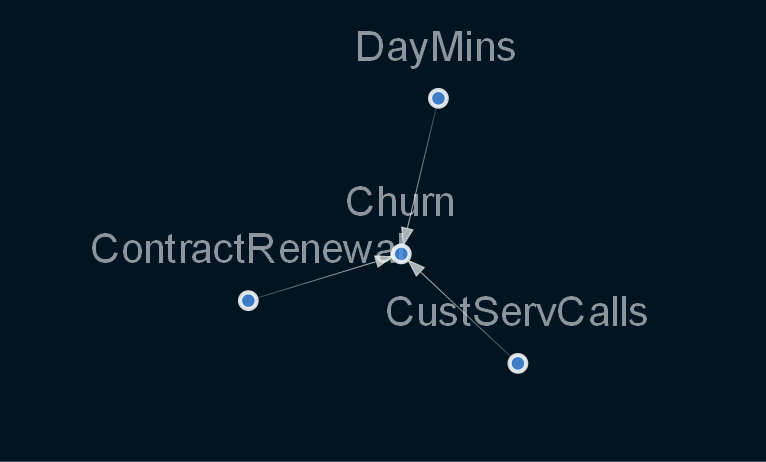

In [5]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [50]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(struct_data,tabu_parent_nodes=['Churn'], w_threshold=0.05)

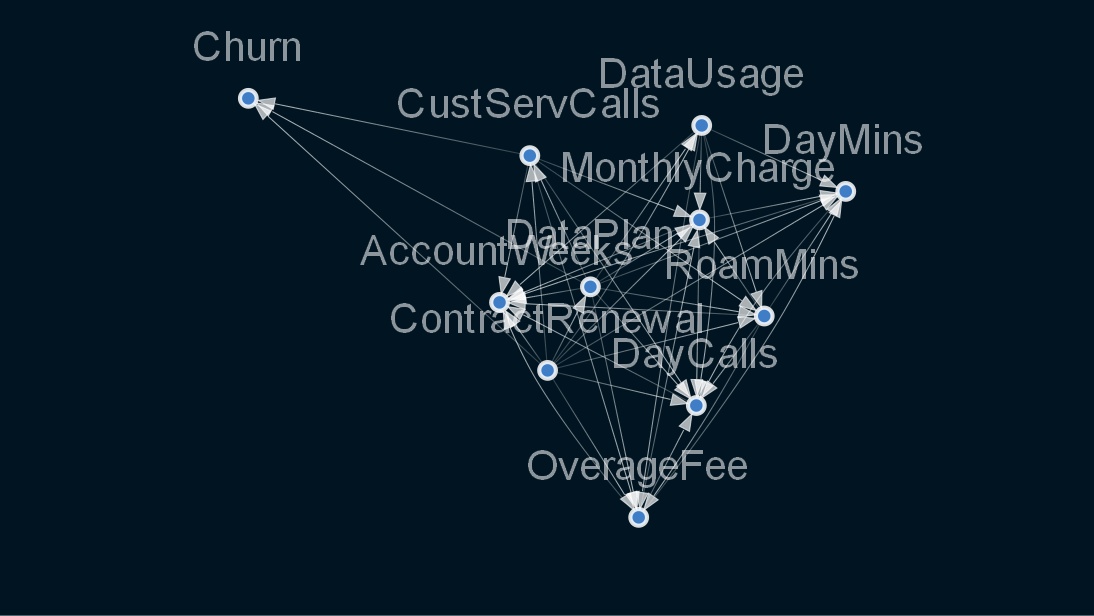

In [51]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

## Bayesian nn

In [52]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

### Discretising  features

In [53]:
from causalnex.discretiser import Discretiser

discretised_data = data.copy()
			
discretised_data["AccountWeeks"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 10]).transform(discretised_data["AccountWeeks"].values)
discretised_data["DataUsage"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["DataUsage"].values)
discretised_data["DayMins"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["DayMins"].values)
discretised_data["DayCalls"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["DayCalls"].values)
discretised_data["MonthlyCharge"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["MonthlyCharge"].values)
discretised_data["OverageFee"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["OverageFee"].values)
discretised_data["RoamMins"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["RoamMins"].values)

### Model training

In [55]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

bn = bn.fit_node_states(discretised_data)

In [56]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [62]:
bn.cpds["Churn"]

ContractRenewal         0                                                \
CustServCalls           0                   1                   2         
DataPlan                0         1         0         1         0     1   
Churn                                                                     
0                0.563636  0.583333  0.652174  0.636364  0.520833  0.75   
1                0.436364  0.416667  0.347826  0.363636  0.479167  0.25   

ContractRenewal                                  ...         1        \
CustServCalls           3           4            ...         5         
DataPlan                0    1      0         1  ...         0     1   
Churn                                            ...                   
0                0.655172  0.4  0.375  0.571429  ...  0.363636  0.75   
1                0.344828  0.6  0.625  0.428571  ...  0.636364  0.25   

ContractRenewal                                                         \
CustServCalls           6              7                   8             
DataPlan                0    1         0         1         0         1   
Churn                                                                    
0                0.357143  0.3  0.333333  0.666667  0.333333  0.666667   
1                0.642857  0.7  0.666667  0.333333  0.666667  0.333333   

ContractRenewal                 
CustServCalls           9       
DataPlan                0    1  
Churn                           
0                0.333333  0.5  
1                0.666667  0.5  

[2 rows x 40 columns]

### Evaluating

In [64]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "Churn")

{'Churn_0': {'precision': 0.8558282208588958,
  'recall': 0.9858657243816255,
  'f1-score': 0.916256157635468,
  'support': 283},
 'Churn_1': {'precision': 0.5,
  'recall': 0.0784313725490196,
  'f1-score': 0.13559322033898305,
  'support': 51},
 'accuracy': 0.8473053892215568,
 'macro avg': {'precision': 0.6779141104294479,
  'recall': 0.5321485484653226,
  'f1-score': 0.5259246889872256,
  'support': 334},
 'weighted avg': {'precision': 0.8014951691708608,
  'recall': 0.8473053892215568,
  'f1-score': 0.797053134275825,
  'support': 334}}

In [66]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "Churn")
print(auc)

0.9113629029366418


### Querying

In [75]:
bn = bn.fit_cpds(discretised_data, method="MaximumLikelihoodEstimator")

In [76]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["Churn"]

{0: 0.5000000000000003, 1: 0.5000000000000003}

In [77]:
low = ie.query({"CustServCalls": 1})
high = ie.query({"CustServCalls": 6})

print("Marginal Churn | Low customer service calls", low["Churn"])
print("Marginal Churn | high customer service calls", high["Churn"])

Marginal Churn | Low customer service calls {0: 0.5, 1: 0.5}
Marginal Churn | high customer service calls {0: 0.5, 1: 0.5}


#### Do calculus

In [79]:
print("distribution before do", ie.query()["CustServCalls"])
ie.do_intervention("CustServCalls",
                   {9:7,
                    8:6,
                    7 : 5,
                    6: 4,
                    5 : 3,
                    4: 2,
                    3:1})
print("distribution after do", ie.query()["CustServCalls"])

distribution before do {0: 0.09999999999999977, 1: 0.09999999999999977, 2: 0.09999999999999977, 3: 0.09999999999999977, 4: 0.09999999999999977, 5: 0.09999999999999977, 6: 0.09999999999999977, 7: 0.09999999999999977, 8: 0.09999999999999977, 9: 0.09999999999999977}


ValueError: The cpd for the provided observation must sum to 1